# Objective:
## Feature Extraction and Fine-Tuning
We'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our cat vs. dog classification model

## Feature Extraction Using a Pretrained Model
We will use the **Inception V3** model developed at Google, and pre-trained on **ImageNet**, a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem
<br><br>
First, we need to pick which intermediate layer of **Inception V3** we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality

In [1]:
import os
from tensorflow.keras import layers, Model

2022-11-21 11:08:17.173063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 11:08:17.252915: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-21 11:08:17.256209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 11:08:17.256216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-11-21 11:09:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.77.144, 142.250.77.112, 142.250.76.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.77.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  5.19MB/s    in 15s     

2022-11-21 11:09:18 (5.66 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction

#### Make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False

The layer we will use for feature extraction in **Inception v3** is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.)

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


#### Stick a fully connected classifier on top of last_output

In [8]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.0001),
             metrics=['acc'])

In [10]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])


train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                   # Since we use binary_crossentropy loss, we need binary labels
                                                   class_mode='binary')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                      target_size=(150,150),
                                                      batch_size=20,
                                                      class_mode='binary')

['cat.421.jpg', 'cat.401.jpg', 'cat.448.jpg', 'cat.21.jpg', 'cat.108.jpg', 'cat.239.jpg', 'cat.201.jpg', 'cat.184.jpg', 'cat.587.jpg', 'cat.694.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=5,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/5


/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 - 32s - loss: 0.0578 - acc: 0.9810 - val_loss: 0.1346 - val_acc: 0.9680 - 32s/epoch - 323ms/step
Epoch 2/5
100/100 - 33s - loss: 0.0740 - acc: 0.9770 - val_loss: 0.1620 - val_acc: 0.9610 - 33s/epoch - 330ms/step
Epoch 3/5
100/100 - 32s - loss: 0.0624 - acc: 0.9790 - val_loss: 0.1543 - val_acc: 0.9620 - 32s/epoch - 323ms/step
Epoch 4/5
100/100 - 33s - loss: 0.0682 - acc: 0.9780 - val_loss: 0.2137 - val_acc: 0.9530 - 33s/epoch - 326ms/step
Epoch 5/5
100/100 - 32s - loss: 0.0802 - acc: 0.9735 - val_loss: 0.1663 - val_acc: 0.9640 - 32s/epoch - 324ms/step


Text(0.5, 1.0, 'Training and Validation Loss')

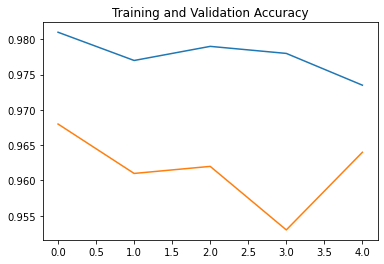

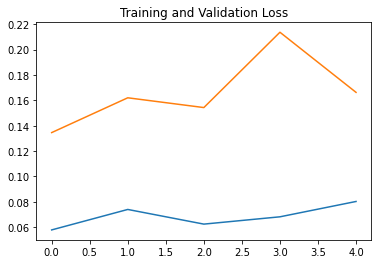

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')

## Further Improving Accuracy with Fine Tuning
**

In [21]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True
        
model.compile(loss='binary_crossentropy',
             optimizer=SGD(lr=0.00001,momentum=0.9),
             metrics=['acc'])

/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/50


/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 - 27s - loss: 0.1559 - acc: 0.9430 - val_loss: 0.1577 - val_acc: 0.9580 - 27s/epoch - 266ms/step
Epoch 2/50
100/100 - 25s - loss: 0.1535 - acc: 0.9555 - val_loss: 0.1796 - val_acc: 0.9530 - 25s/epoch - 251ms/step
Epoch 3/50
100/100 - 25s - loss: 0.1329 - acc: 0.9560 - val_loss: 0.1913 - val_acc: 0.9520 - 25s/epoch - 251ms/step
Epoch 4/50
100/100 - 25s - loss: 0.1279 - acc: 0.9560 - val_loss: 0.1938 - val_acc: 0.9510 - 25s/epoch - 252ms/step
Epoch 5/50
100/100 - 25s - loss: 0.1392 - acc: 0.9530 - val_loss: 0.1945 - val_acc: 0.9510 - 25s/epoch - 252ms/step
Epoch 6/50
100/100 - 25s - loss: 0.1195 - acc: 0.9570 - val_loss: 0.1953 - val_acc: 0.9520 - 25s/epoch - 252ms/step
Epoch 7/50
100/100 - 25s - loss: 0.1227 - acc: 0.9615 - val_loss: 0.1934 - val_acc: 0.9530 - 25s/epoch - 252ms/step
Epoch 8/50
100/100 - 25s - loss: 0.1202 - acc: 0.9610 - val_loss: 0.1915 - val_acc: 0.9550 - 25s/epoch - 253ms/step
Epoch 9/50
100/100 - 25s - loss: 0.1063 - acc: 0.9610 - val_loss: 0.1894 - val_acc:

Text(0.5, 1.0, 'Training and Validation Loss')

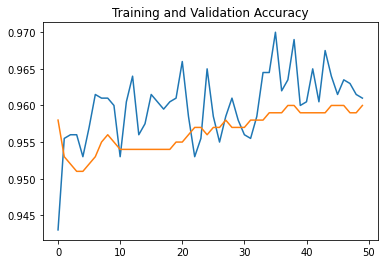

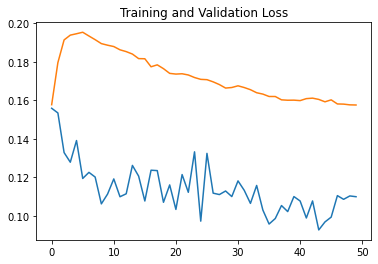

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)